# Distributed Stochastic Gradient Decent with Spark

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from revrand.optimize import (minimize, sgd_u, sgd_u_spark)
from revrand.optimize.sgd_updater import (AdaGrad, AdaDelta, Momentum)
from revrand.basis_functions import RadialBasis
import logging

Objective function:

In [2]:
def f(w, Data, sigma=1.0):
    y, Phi = Data[:, 0], Data[:, 1:]
    logp = -1.0 / (2 * sigma * sigma) * ((y - Phi.dot(w))**2).sum()
    d = 1.0 / (sigma * sigma) * Phi.T.dot((y - Phi.dot(w)))
    return -logp, -d

Setup. Create dataset.

In [3]:
batchsize = 100
var = 0.05
nPoints = 1000
nQueries = 500
passes = 200
min_grad_norm = 0.01
rate = 0.95
eta = 1e-6

# Create dataset
X = np.linspace(0.0, 1.0, nPoints)[:, np.newaxis]
Y = np.sin(2 * np.pi * X.flatten()) + np.random.randn(nPoints) * var
centres = np.linspace(0.0, 1.0, 20)[:, np.newaxis]
Phi = RadialBasis(centres)(X, 0.1)
train_dat = np.hstack((Y[:, np.newaxis], Phi))

Xs = np.linspace(0.0, 1.0, nQueries)[:, np.newaxis]
Yt = np.sin(2 * np.pi * Xs.flatten())
Phi_s = RadialBasis(centres)(Xs, 0.1)
w = np.linalg.solve(Phi.T.dot(Phi), Phi.T.dot(Y))
Ys = Phi_s.dot(w)

L-BFGS approach to test objective:

In [4]:
w0 = np.random.randn(Phi.shape[1])
results = minimize(f, w0, args=(train_dat,), jac=True, method='L-BFGS-B')
w_grad = results['x']
Ys_grad = Phi_s.dot(w_grad)

SGD for learning w (AdaDelta):

In [5]:
w0 = np.random.randn(Phi.shape[1])
results = sgd_u(f, w0, train_dat, updater=AdaDelta(), 
                passes=passes, batchsize=batchsize, 
                eval_obj=True, gtol=min_grad_norm)
w_sgd_ad, gnorms_ad, costs_ad = results['x'], results['norms'], results['objs']
Ys_sgd_ad = Phi_s.dot(w_sgd_ad)

Create Spark RDD (Resilient Distributed Dataset):

In [6]:
rdd = sc.parallelize(train_dat)
N = rdd.count()
q = rdd.getNumPartitions()
print("Training data RDD: {} data points across {} partitions.".format(N,q))

Training data RDD: 1000 data points across 6 partitions.


Distributed SGD (AdaDelta). This takes a while (view Spark jobs on port 4040 and Mesos master on port 5050)

In [7]:
w0 = np.random.randn(Phi.shape[1])
results = sgd_u_spark(f, w0, rdd, updater=AdaDelta(), 
                      passes=passes,
                      batchsize=batchsize, eval_obj=True, 
                      gtol=min_grad_norm)

w_sgd_dad, gnorms_dad, costs_dad = results['x'], results['norms'], results['objs']
Ys_sgd_dad = Phi_s.dot(w_sgd_dad)

In [8]:
def print_res(method, cost):
    print("{0: >20}: {1}".format(method,cost))
print_res("AdaDelta", costs_ad[-1])
print_res("Dist. AdaDelta", costs_dad[-1])

            AdaDelta: 0.1464021566119116
      Dist. AdaDelta: 0.21104591225864547


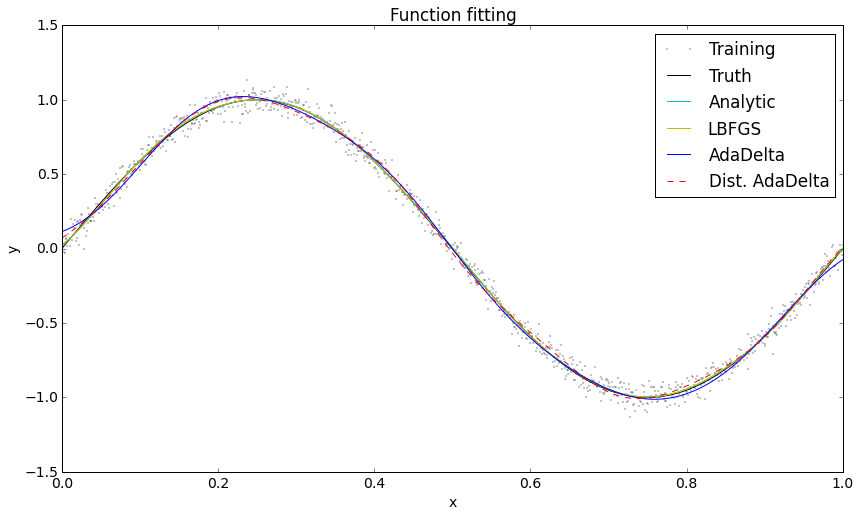

In [9]:
mpl.rcParams['figure.figsize'] = (14.0, 8.0)
mpl.rcParams['font.size'] = 14
fig = plt.figure()
plt.plot(X, Y, 'k.', Xs, Yt, 'k-', markersize=1)
plt.plot(Xs, Ys, 'c-')
plt.plot(Xs, Ys_grad, 'y-')
plt.plot(Xs, Ys_sgd_ad, 'b-')
plt.plot(Xs, Ys_sgd_dad, 'r--')
plt.title('Function fitting')
labels = ['Training', 'Truth', 'Analytic', 'LBFGS', 'AdaDelta', 'Dist. AdaDelta']
plt.legend(labels)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


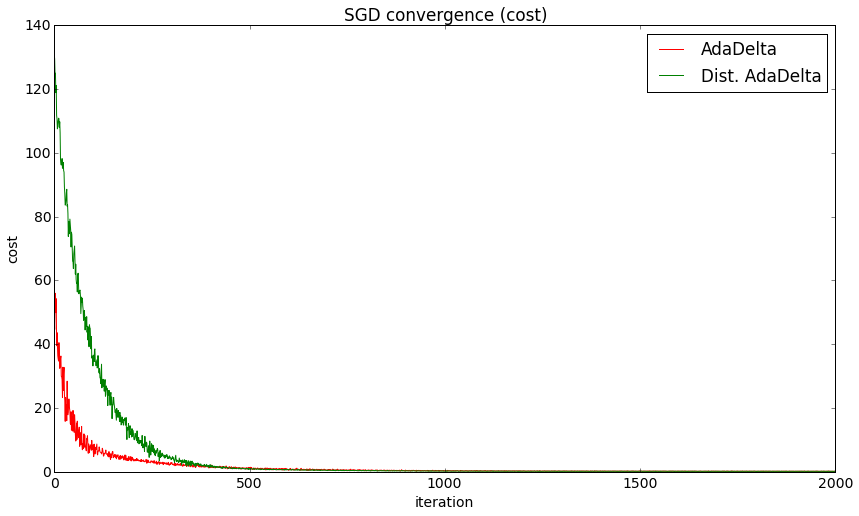

In [10]:
fig = plt.figure()
plt.xlabel('iteration')
plt.title('SGD convergence (cost)')
plt.plot(range(len(costs_ad)), costs_ad, 'r')
plt.plot(range(len(costs_dad)), costs_dad, 'g')
labels = ['AdaDelta', 'Dist. AdaDelta']
plt.ylabel('cost')
plt.legend(labels)
plt.show()

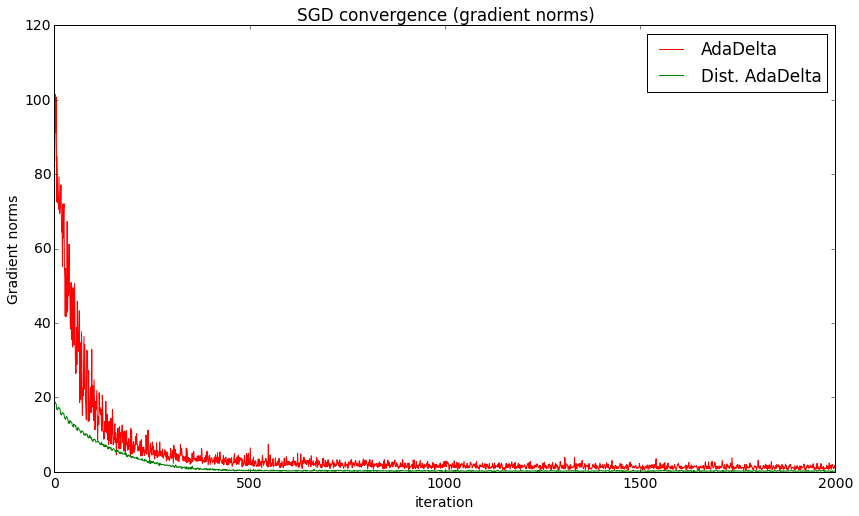

In [11]:
fig = plt.figure()
plt.xlabel('iteration')
plt.title('SGD convergence (gradient norms)')
plt.plot(range(len(gnorms_ad)), gnorms_ad, 'r')
plt.plot(range(len(gnorms_dad)), gnorms_dad, 'g')
labels = ['AdaDelta', 'Dist. AdaDelta']
plt.ylabel('Gradient norms')
plt.legend(labels)
plt.show()